### Contributor: Sudesh Kumar Santhosh Kumar
- Email: sudeshkumar.santhoshkumar@lexisnexis.com
- Date: 21st June, 2023

Description:  This Notebook will show you how to fine-tune BERT for multi-class text classification tasks, meaning that there are more than just two classes in the dataset. We'll be using the 20 Newsgroups dataset, which is a test classification dataset with 20 different classes. 

**Multi-Label vs. Multi-Class**

It is important to distinguish between "Multi-Class" and "Multi-Label" as they pertain to different types of tasks and are handled differently.

In "Multi-Label" classification, documents can be assigned multiple labels. This means that a document may have several appropriate tags or categories associated with it. For instance, consider a system that suggests tags for documents where multiple tags may be relevant.

On the other hand, "Multi-Class" classification applies when each document is assigned only one category. If there are only two possible categories, it is known as "Binary" classification. If there are more than two categories, it is referred to as "Multi-Class" classification. In this scenario, each document is assigned to a single category, without the possibility of multiple labels.

By understanding these distinctions, we can appropriately handle and address the requirements of each type of classification task.

# Part I - Installation, Loading Dataset and Tokenization
---------------------------------

## S1. Setting up the Notebook


### 1.1. Basic Pre-requisites and Installations

If you're using this notebook on Google Colab, Don't forget to uncomment the following cell to install transformers library into the notebook. If you're using this notebook on your local machine through VS Code or Jupyter notebook, you need to do a "pip install -r requirements.txt" before running the following set of code blocks.

In [1]:
# !pip install transformers

### 1.2. Importing all necessary libraries

In [2]:
import textwrap
import random
import csv
import os
import time
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics




### 1.3. Connecting to GPU 

In [3]:
# Checking if there is a GPU Available.
if torch.cuda.is_available():

    device = torch.device(("cuda"))
    print(f"There are {torch.cuda.device_count()} available.")
    print(f"We will use the GPU: {torch.cuda.get_device_name(0)}")

else:
    print("No GPU available, using the CPU!")
    device = torch.device("cpu")

No GPU available, using the CPU!


## S2. Load Dataset from scikit-learn and Inspect it

### 2.1. import dataset from scikit-learn

The 20 Newsgroups dataset is old (from the 1990s?), and contains what today we would probably call "forum posts", coming from 20 different subtopics. 

The 20 categories (or) classes are as follows:

* comp.graphics
* comp.os.ms-windows.misc
* comp.sys.ibm.pc.hardware
* comp.sys.mac.hardware
* comp.windows.x	
* rec.autos
* rec.motorcycles
* rec.sport.baseball
* rec.sport.hockey	
* sci.crypt
* sci.electronics
* sci.med
* sci.space
* misc.forsale	
* talk.politics.misc
* talk.politics.guns
* talk.politics.mideast	
* talk.religion.misc
* alt.atheism
* soc.religion.christian

Scikit-learn includes some nice helper functions for retrieving the 20 Newsgroups dataset (from their example [here](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html)). We'll use them below to retrieve the dataset.


In [4]:
# Removing the meta-data from the train and test subsets.
train = fetch_20newsgroups(subset='train',
                           remove=('headers', 'footers', 'quotes'))

test = fetch_20newsgroups(subset='test',
                           remove=('headers', 'footers', 'quotes'))

### 2.2. Inspecting the data

In [5]:
# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

# Randomly choose some examples.
for i in range(10):
    
    # Choose a random sample by index.
    j = random.choice(range(len(train.data)))
    
    # Get the text as 'x' and the label integer as 'y'.
    x = train.data[j]
    y = train.target[j]

    # Print out the name of the category and the text.
    print('')
    print('========', train.target_names[y], '========')
    print(wrapper.fill(x))
    print('')



======== sci.space ========
of   A transporter operator!?!?  That better be one important transport.
Usually   it is a nameless ensign who does the job.  For such a guest appearance
I would   have expected a more visible/meaningful role.  ---
---------------------------------------------------------------------


======== comp.sys.ibm.pc.hardware ========
thought I'd post this as well as e-mail it, just in case anyone else is
interested in this info.....     I suggest that you go direct to the original
(and preferred...best quality) source for all of this, just as you would (at
least, should) for the chips themselves:  National Semiconductor.  you can reach
them at 1-800-272-9959. they no longer package the data sheets in a book, as
they did when I got mine, but you can get them as individual sets of data
sheets.  you want, as a minimum, the following:     *) 2 sets of data sheets:
*) NS16450/INS8250A/NS16C450/INS82C50A       *) NS16550AF     *) 2 application
notes (yes, GET THESE!): 

### 2.3. Exploratory Data Analysis and Checking for imbalances in the dataset.

In [20]:
print(f"Total number of Data-points in the Train Data: {len(train.data)}")
print(f"Total number of data-points in the Test Data: {len(test.data)}")
print(f"Total number of classes in the Data-set, C = {len(np.unique(np.array(train.target)))}")

Total number of Data-points in the Train Data: 11314
Total number of data-points in the Test Data: 7532
Total number of classes in the Data-set, C = 20


Text(0, 0.5, '# of Training Samples')

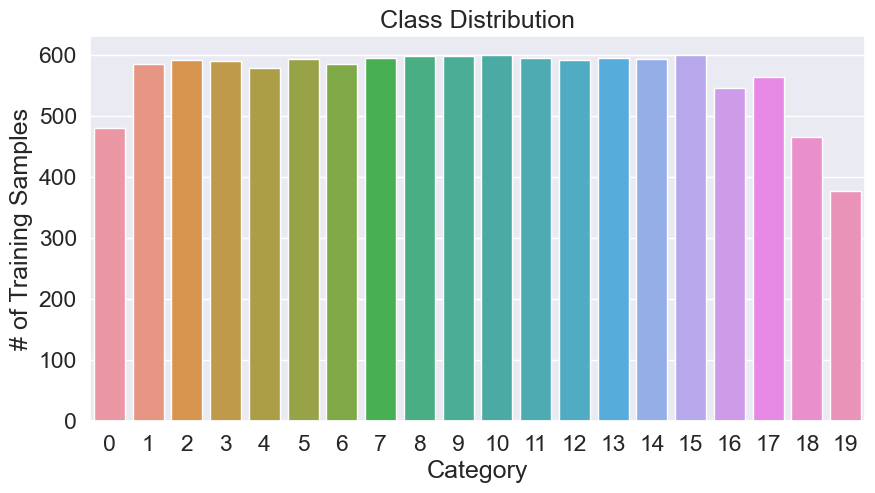

In [17]:

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)


# Plot the number of tokens of each length.
sns.countplot(x=train.target)
plt.title('Class Distribution')
plt.xlabel('Category')
plt.ylabel('# of Training Samples')


Except class 19, which corresponds to 'talk.religion.misc', every other class is well balanced.

In [7]:
train.target_names[19]

'talk.religion.misc'

## S3. Tokenization using BertTokenizer.

### 3.1 Loading the BertTokenizer.

To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary. The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.

In [21]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [22]:
# Sample Toeknization Example.
# Print the original sentence.
print(' Original: ', train.data[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train.data[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train.data[0])))

 Original:  I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.
Tokenized:  ['i', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'en', '##light', '##en', 'me', 'on', 'this', 'car', 'i', 'saw', 'the', 'other', 'day', '.', 'it', 'was', 'a', '2', '-', 'door', 'sports', 'car', ',', 'looked', 'to', 'be', 'from', 'the', 'late', '60s', '/', 'early', '70s', '.', 'it', 'was', 'called', 'a', 'brick', '##lin', '.', 'the', 'doors', 'were', 'really', 'small', '.', 'in', 'addition', ',', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'b

### 3.2. Tokenize All Samples

The tokenizer.encode function combines multiple steps for us:

* Split the sentence into tokens.
* Add the special [CLS] and [SEP] tokens.
* Map the tokens to their IDs.

In order to explore the distribution of sequence lengths, we will not perform any truncation here. Unfortunately, this results in the tokenizer spitting out a warning for every sample that's longer than 512 tokens. We'll just have to ignore those for now!

In [24]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# Record the length of each sequence (in terms of BERT tokens).
lengths = []

print('Tokenizing the input sentences in train data (11314 examples)')

# For every sentence...
for sentence in train.data:

    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sentence,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        #max_length = 512,          # Truncate all sentences.                        
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

    # Record the non-truncated length.
    lengths.append(len(encoded_sent))

print('Tokenization Process Completed.')
print(f"Tokenized {len(train.data)} sentences from the Train Data!")

Tokenizing the input sentences in train data (11314 examples)
Tokenization Process Completed.
Tokenized 11314 sentences from the Train Data!


### 3.3. Understanding the distribution of sentence lengths in the Train Data.

In [27]:
print(f"Min length: {min(lengths)} tokens")
print(f'Max length: {max(lengths)} tokens')
print(f'Median length: {np.median(lengths)} tokens')

Min length: 2 tokens
Max length: 52886 tokens
Median length: 124.0 tokens


### 3.4. Analysing the percentage of data over the 512 limit

In [28]:
num_over = 0

# For all of the length values...
for length in lengths:
    # Tally if it's over 512.
    if length > 512:
        num_over += 1

print('{:,} of {:,} comments will be truncated ({:.2%})'.format(num_over, len(lengths), float(num_over) / float(len(lengths))))

1,015 of 11,314 comments will be truncated (8.97%)


The BERT-base-uncased model indeed uses an embedding layer with weights of dimension 30522 x 768 for the wordpiece vocabulary.

In BERT, the first embedding layer is known as the token embedding layer, and it maps the input wordpiece IDs to their corresponding embedding vectors. The vocabulary size in BERT-base-uncased is 30522, meaning it can handle up to 30522 different wordpiece tokens.

Each wordpiece token in the vocabulary is associated with a 768-dimensional embedding vector. Therefore, the embedding layer in BERT-base-uncased has weights with dimensions of 30522 x 768, where each row corresponds to the embedding vector of a specific wordpiece token in the vocabulary.

Before converting text to wordpiece tokens in BERT, there is typically a limit on the maximum number of tokens in a sentence. This limit is often referred to as the "maximum sequence length" or MAX_LEN.

In BERT, the maximum sequence length is determined based on the architecture and configuration of the specific model being used. The most common maximum sequence length used in BERT models is 512 tokens.

If a sentence has more than the maximum sequence length, it needs to be truncated or split into smaller parts to fit within the limit. Truncation involves discarding tokens from the end of the sentence, while splitting involves dividing the sentence into multiple segments or chunks.

### 3.5. Truncating the longer sentences and Perform Tokenization

Given the higher percentage of longer-than-512-tokens samples, I thought it might make sense to try a maximum length of 512 for this example. However, with batch_size = 32 and max_len = 512, I ran into a GPU out-of-memory error on the first iteration of the training loop!

After performing some analysis and a number of experiment,

* If the combination of your batch_size and max_len are too high, then you can easily run out of memory (even on a Tesla K80 with 12GB!) when fine-tuning BERT-base. For example, with batch_size = 16, a max_len = ~400 is about the limit on a Tesla K80.
* Reducing batch_size reduces memory consumption, but at the cost of slower training, and finding the best choice of batch_size appears to be important for accuracy.
* Reducing max_len reduces memory consumption and speeds up training, but has a substantial impact on BERT's accuracy on this benchmark.

In [29]:
max_len = 300

In [30]:
def my_tokenize(comments, labels, max_len):
    '''
    Tokenize a dataset of comments.

    Parameters:
      `comments` - List of comments, represented as strings.
        `labels` - List of integer labels for the corresponding comments.
       `max_len` - Truncate all of the comments down to this length.
    
    Returns:
      `input_ids` - All of the comments represented as lists of token IDs,
                    padded out to `max_len`, and cast as a PyTorch tensor.
         `labels` - The labels for the corresponding comments, formatted as 
                    a PyTorch tensor.
      `attention_masks` - PyTorch tensor with the same dimensions as
                          `input_ids`. For each token, simply indicates whether
                           it is padding or not.
    '''
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    print('Tokenizing {:,} comments...'.format(len(comments)))

    # For every comment ("sentence")...
    for sent in comments:

        # Report progress.
        if ((len(input_ids) % 500) == 0):
            print('  Tokenized {:,} comments.'.format(len(input_ids)))

        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_len,      # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                    )
        
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Convert the labels to a tensor.
    labels = torch.tensor(labels)

    return (input_ids, labels, attention_masks)
